In [46]:
import os
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
from keras.models import Sequential
from keras.layers import Cropping2D, Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Lambda, Dropout

samples = []
with open('./training_data/test_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        # we only need the first 4 columns of data for this project
        # which is the center, left, right image paths and steering angle
        data = line[0:4]
        samples.append(data)

# TODO: only for debug, show image shape
file = './training_data/IMG/'+samples[0][0].split('/')[-1]
image = cv2.imread(file)
print("Image shape is: ", image.shape)
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# implement a generator function to save memory and load data on the fly
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        # we shuffle samples in the generator.  Without a generator we
        # can simply shuffle with on option in model.fit
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # adjust the filename/path since orig logged on a local machine
                # filename is the last part of the sample path
                # TODO eventually will want to add left & right images
                center_filename = './training_data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(center_filename)
                # TODO remove
                # center_image = image_adjust(center_image)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # convert image and angle data to np arrays as reqd by Keras
            X_train = np.array(images)
            y_train = np.array(angles)
            # yield sklearn.utils.shuffle(X_train, y_train) - example but why shuffle again??
            yield (X_train, y_train)

# TODO: remove this as cropping & preprocess done in Keras is more efficient
def image_adjust(image):
    # make adjustments like cropping etc to training images
    # original image is 320x160, crop top & bottom
    # crop slice syntax is image[y1:y2, x1:x2]
    image = image[40:140,0:320]
    # scale the image to reduce it's size and future processing
    # image = skimage.transform.resize(image, (50, 160, 3))
    return image

row, col, ch = 160, 320, 3  # Image dimensions

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model = Sequential()

# crop 50 pixels from the top and 20 from the bottom of the image
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(row, col, ch)))
row, col, ch = 90, 320, 3  # Trimmed image format 160-50-20

# Preprocess incoming data, centered around zero with small standard deviation
# note - need to verify if sklearn resize already scaled pixel values
model.add(Lambda(lambda x: x/127.5 - 1.,
        output_shape=(row, col, ch)))

# implement the Nvidia model architecture though it may be more complex
# than needed for this application https://arxiv.org/pdf/1604.07316.pdf
# 3 5x5 conv layers with 2x2 strides with depth 24, 36, 48 respectively
# 2 3x3 unstrided conv layers of depth 64
# Flatten layers of depth 100, 50, & 10 respectively
# 3 FC layers
# assume we need some dropout on the FC layers, use 0.5 to start
# NOTE: we have an old version of Keras which differs from documented
# arguments.  See http://stackoverflow.com/questions/38681407/how-can-implement-subsample-like-keras-in-tensorflow
# subsample is the same as strides in the current documentation & Tensorflow
#model.add(Conv2D(24, 5, 5, subsample=(2, 2), input_shape=(row, 320, 3), activation='relu'))
model.add(Conv2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Conv2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Conv2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()
# we are using mse loss rather than cross entropy since we are just trying
# to minimize steering angle pred vs labeled
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator,
                    samples_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=3)
model.save('model.h5')


Image shape is:  (160, 320, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_60 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_35[0][0]        
____________________________________________________________________________________________________
lambda_39 (Lambda)               (None, 90, 320, 3)    0           cropping2d_60[0][0]              
____________________________________________________________________________________________________
convolution2d_103 (Convolution2D (None, 43, 158, 24)   1824        lambda_39[0][0]                  
____________________________________________________________________________________________________
convolution2d_104 (Convolution2D (None, 20, 77, 36)    21636       convolution2d_103[0][0]          
____________________________________________________________

Image shape is:  (160, 320, 3)
angle:  -0.0
angle:  -0.25
angle:  0.25
Cropped Images:


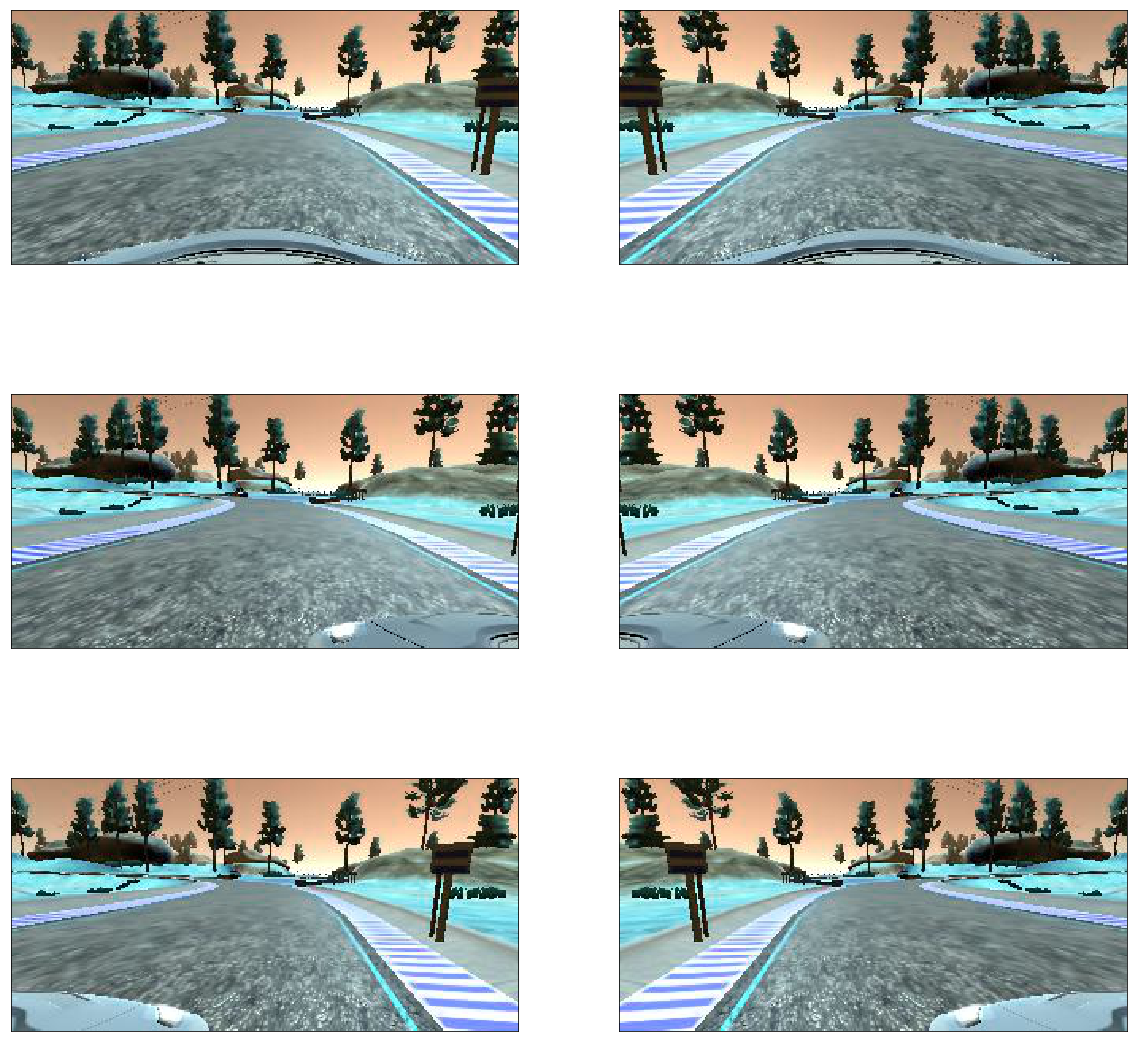

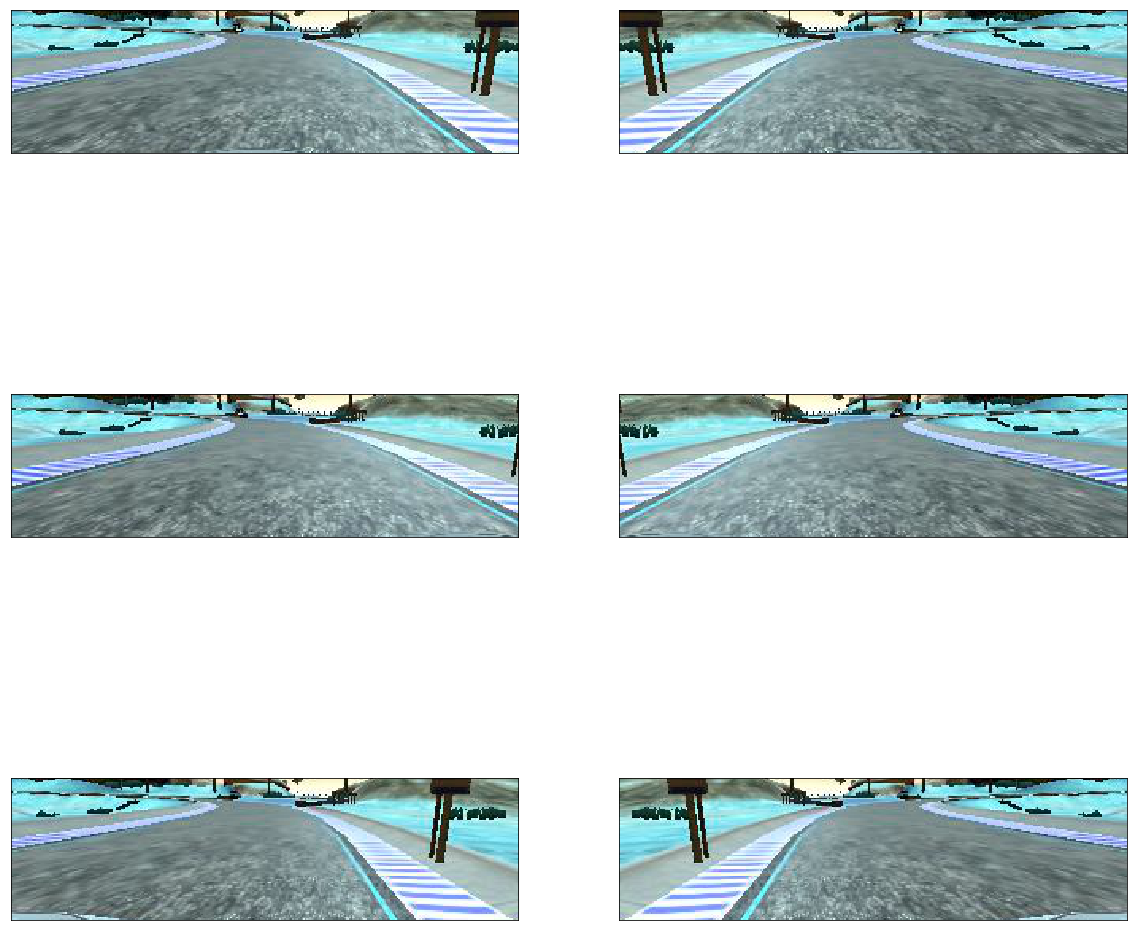

In [1]:
## Visualize the augmented images

import os
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

path = './training_data/'
# driving_log.csv or test_log.csv
data_file = 'test_log.csv'

samples = []
with open('./training_data/test_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        # we only need the first 4 columns of data for this project
        # which is the center, left, right image paths and steering angle
        data = line[0:4]
        samples.append(data)

# TODO: only for debug, show image shape
file = './training_data/IMG/'+samples[0][0].split('/')[-1]
image = cv2.imread(file)
print("Image shape is: ", image.shape)
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# implement a generator function to save memory and load data on the fly
num_samples = len(samples)
        # we shuffle samples in the generator.  Without a generator we
        # can simply shuffle with on option in model.fit
shuffle(samples)

images = []
angles = []
for batch_sample in samples:
    angle_adjustment = [0., 0.25, -0.25]
    for i in range(0,3):
                # adjust the filename/path since orig logged on a local machine
                # filename is the last part of the sample path
        file = path + 'IMG/' + batch_sample[i].split('/')[-1]
        image = cv2.imread(file)
        angle = float(batch_sample[3]) + angle_adjustment[i]
        images.append(image)
        angles.append(angle)
                    # augment with a flipped version of this image since track
                    # is primarily left turning
        image = image[:, ::-1, :]
        images.append(image)
        angles.append(-angle)

plt.close('all')
fig = plt.figure(figsize=(20,20))
# visualize a set of augmented images 
for i in range(6):
    if (i%2): print("angle: ", angles[i])
    ax = fig.add_subplot(3, 2, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].squeeze())
    
print("Cropped Images:")
# plt.close('all')
fig = plt.figure(figsize=(20,20))
# visualize a set of augmented images 
for i in range(6):
    # print("i: ", i)
    image = images[i][50:140,0:320]
    ax = fig.add_subplot(3, 2, i + 1, xticks=[], yticks=[])
    ax.imshow(image.squeeze())

In [13]:
# Note in the above images the steering adjustment seems to overcorrect substantially
# try ~ 0.1 vs 0.25

# of samples 8726


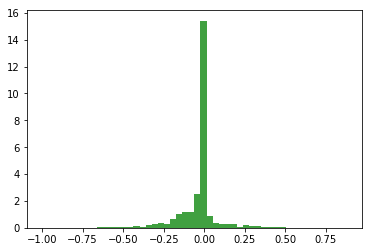

In [17]:
# visualize data
path = './training_data/'
# driving_log.csv or test_log.csv
data_file = 'driving_log.csv'

samples = []
file = path + data_file
with open(file) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        # we only need the first 4 columns of data for this project
        # which is the center, left, right image paths and steering angle
        data = line[0:4]
        samples.append(data)
angles = []
print("# of samples", len(samples))
for i in samples:
    angles.append(i[3])
x = np.array(angles).astype(np.float)
# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()